In [2]:
import osmnx as ox
import folium
import requests
import pandas as pd
import networkx as nx
import webbrowser
import numpy as np
from IPython.display import IFrame

In [3]:
G = ox.graph_from_place('Singapore', network_type='drive',retain_all=False)
# impute missing edge speed and add travel times
G = ox.add_edge_speeds(G,agg=np.mean)
G = ox.add_edge_travel_times(G)
G = ox.utils_graph.remove_isolated_nodes(G)

In [4]:
Gs = ox.utils_graph.get_largest_component(G, strongly=True)

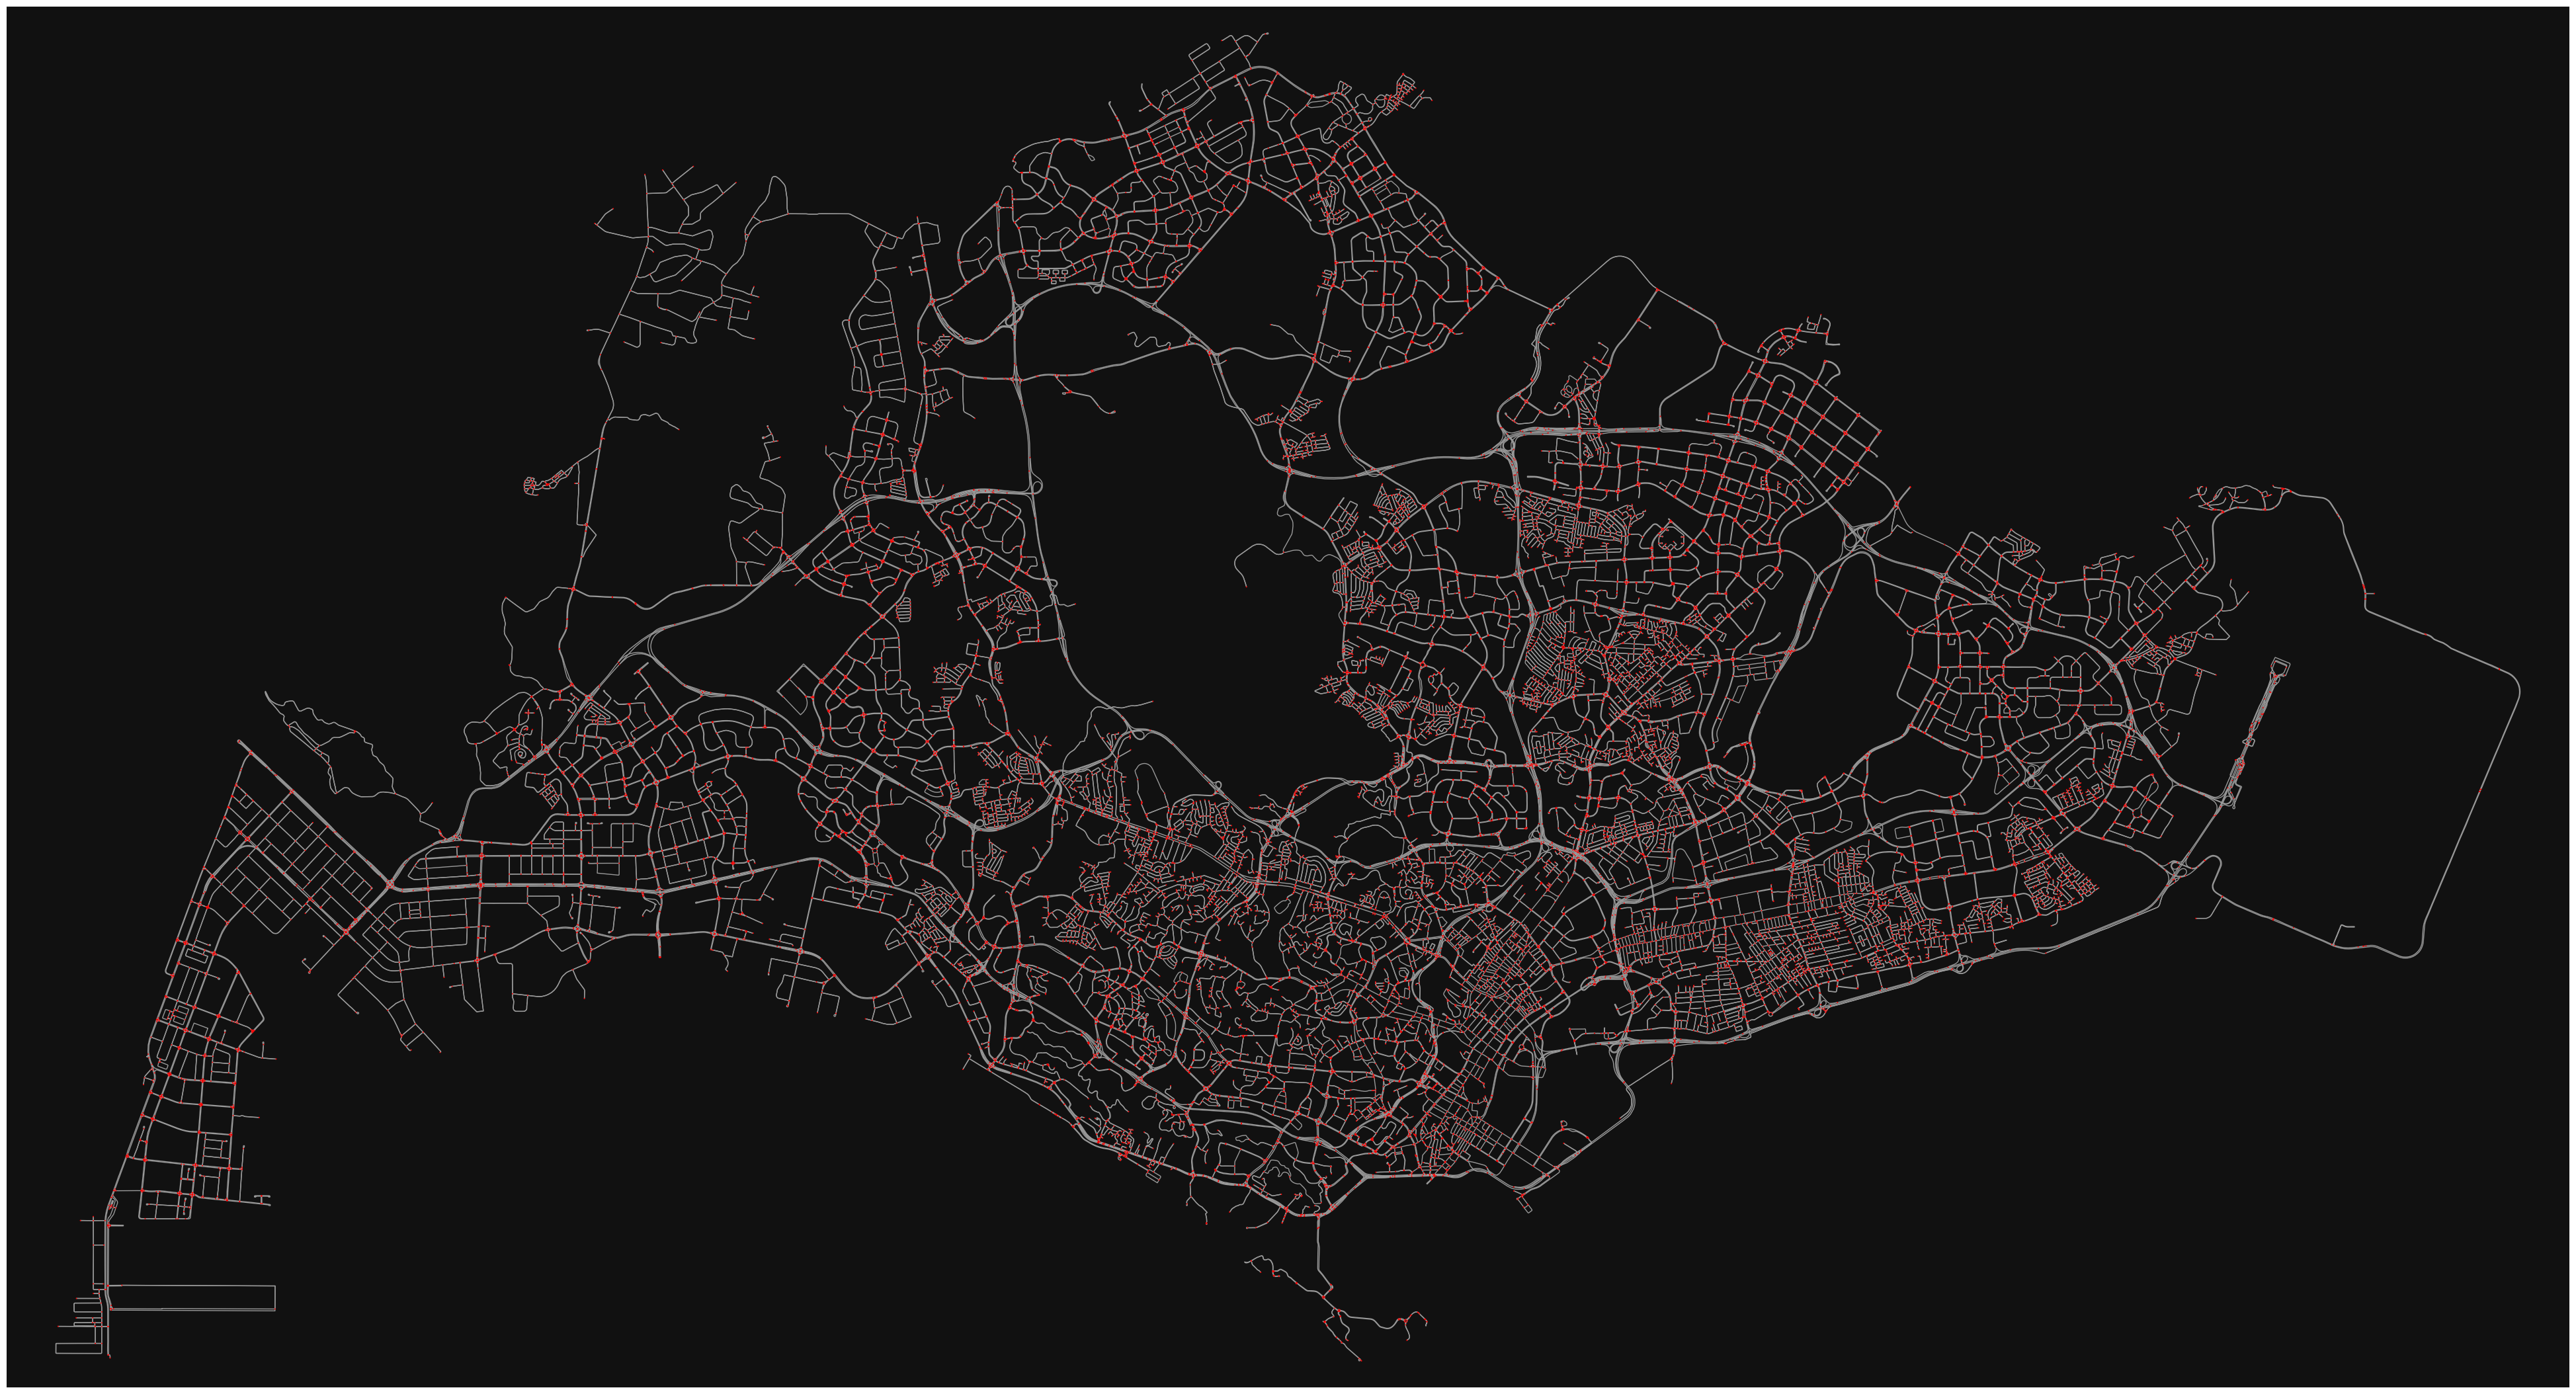

(<Figure size 5000x5000 with 1 Axes>, <Axes: >)

In [5]:
ox.plot_graph(Gs, ax=None, figsize=(50, 50), bgcolor='#111111', node_color='r', node_size=2, node_alpha=None, node_edgecolor='none', node_zorder=1, edge_color='#999999', edge_linewidth=1, edge_alpha=None, show=True, close=False, save=False, filepath=None,  bbox=None)

In [6]:
ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)[0]

,y,x,street_count,ref,highway,geometry
osmid,,,,,,
25451929,1.295232,103.872544,3,NaN,NaN,POINT (103.87254 1.29523)
25455287,1.295445,103.874004,3,14A,motorway_junction,POINT (103.87400 1.29544)
26777521,1.303979,103.823571,3,NaN,NaN,POINT (103.82357 1.30398)
26778779,1.304654,103.851530,3,NaN,NaN,POINT (103.85153 1.30465)
26778790,1.301522,103.850021,4,NaN,traffic_signals,POINT (103.85002 1.30152)
...,...,...,...,...,...,...
10170398180,1.315513,103.943323,4,NaN,NaN,POINT (103.94332 1.31551)
10170398182,1.315335,103.943243,1,NaN,NaN,POINT (103.94324 1.31533)
10170398183,1.315580,103.943303,3,NaN,NaN,POINT (103.94330 1.31558)


In [7]:
import requests

# Initialize an empty list to store valid postal codes
valid_postal_codes = []

# Start an interactive session
while True:
    user_input_postal = input("Enter postal code (or type 'done' to finish): ")

    # Check if the user wants to end the session
    if user_input_postal.lower() == 'done':
        break

    try:
        # Try to convert the input to an integer
        postal_code = int(user_input_postal)

        # Check if the integer has exactly 6 digits
        if 100000 <= postal_code <= 999999:
            valid_postal_codes.append(postal_code)
        else:
            print("Invalid postal code. It should have exactly 6 digits.")

    except ValueError:
        print("Invalid input. Please enter a valid integer.")

# Display the collected valid postal codes
print("Collected Postal Codes:", valid_postal_codes)


Invalid input. Please enter a valid integer.
Invalid input. Please enter a valid integer.
Invalid input. Please enter a valid integer.
Collected Postal Codes: []


In [8]:
import requests
import pandas as pd

# Initialize an empty list to store data
data_list = []

# Iterate through valid_postal_codes
for postal_code in valid_postal_codes:
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={postal_code}&returnGeom=Y&getAddrDetails=N"
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the response content as JSON
        result = response.json()['results'][0]

        # Extract relevant information
        latitude = result['LATITUDE']
        longitude = result['LONGITUDE']

        # Append data to the list
        data_list.append({'PostalCode': postal_code, 'Latitude': float(latitude), 'Longitude': float(longitude)})
    else:
        print(f"Request failed for postal code {postal_code} with status code {response.status_code}: {response.text}")

# Create a DataFrame from the collected data
query_database = pd.DataFrame(data_list)

# Display the DataFrame
print(query_database)


Empty DataFrame
Columns: []
Index: []


In [9]:
# Extract node data
nodes = ox.graph_to_gdfs(G, edges=False)

# Display the DataFrame containing node data
node_id = nodes[['x', 'y']]
node_id_df = node_id.reset_index()
node_id_df


,osmid,x,y
0,25451929,103.872544,1.295232
1,25455287,103.874004,1.295445
2,26777521,103.823571,1.303979
3,26778779,103.851530,1.304654
4,26778790,103.850021,1.301522
...,...,...,...
23873,10170398180,103.943323,1.315513
23874,10170398182,103.943243,1.315335
23875,10170398183,103.943303,1.315580
23876,10732302222,103.906146,1.305970


In [10]:
def find_closest_row(node_id_df, x_val, y_val):
    # Calculate the Euclidean distance between each row's (x, y) and the given values
    node_id_df['distance'] = ((node_id_df['x'] - x_val) ** 2 + (node_id_df['y'] - y_val) ** 2) ** 0.5

    # Find the index of the row with the minimum distance
    closest_row_index = node_id_df['distance'].idxmin()

    # Get the row using the index
    closest_row = node_id_df.loc[closest_row_index]

    # Drop the distance column if you don't need it in the result
    closest_row = closest_row.drop('distance')

    return closest_row


In [11]:
import pandas as pd

# Assuming query_database and node_id_df are your DataFrames

result_list = []

for index, rows in query_database.iterrows():
    postal_code = rows["PostalCode"]
    x_val = rows["Longitude"]
    y_val = rows["Latitude"]

    result_row = find_closest_row(node_id_df, x_val, y_val)
    # Append data to the result_list for each iteration
    result_list.append([result_row["osmid"], postal_code, x_val, y_val])

# Create a DataFrame from the result_list
columns = ["osmid", "PostalCode", "Longitude", "Latitude"]
result_df = pd.DataFrame(result_list, columns=columns)

# Display the resulting DataFrame
result_df


,osmid,PostalCode,Longitude,Latitude


In [12]:
route = ox.routing.shortest_path(G,possible_routes[index],possible_routes[index+1],weight='Speed')
full_route = ox.utils_graph.route_to_gdf(G, route)

NameError: name 'possible_routes' is not defined

In [ ]:
result_df["osmid"][0]

7384225390.0

In [ ]:
for index, rows in result_df.iterrows():


In [ ]:
from itertools import permutations

# Keep the first and last elements fixed, permutate the rest
middle_permutations = list(permutations(result_df["osmid"]))
middle_permutations

# Filter permutations that start at 0 and end at 5
filtered_permutations = [perm for perm in middle_permutations if perm[0] == result_df["osmid"][0] and perm[-1] == result_df["osmid"][4]]

route_distance_list = {}

for possible_routes in filtered_permutations:
    #print(possible_routes,len(possible_routes))
    for index in range(len(possible_routes)-1):
        #print(possible_routes[index])
        route = ox.routing.shortest_path(G,possible_routes[index],possible_routes[index+1],weight='length')
        full_route = ox.utils_graph.route_to_gdf(G, route)
        length_of_full_route = full_route["length"].sum()
        route_distance_list[possible_routes]=length_of_full_route

best_route = min(route_distance_list, key=lambda k: route_distance_list[k])


# Create a DataFrame with keys for merging
keys_df = pd.DataFrame({"osmid": best_route})

# Merge to get the corresponding information in the specified order
final_df = pd.merge(keys_df, result_df, on="osmid")

final_df = final_df.reset_index()


In [ ]:
best_route = (4602352792.0, 244495528.0, 7384225390.0, 1218554499.0, 5204064003.0)

In [ ]:
# Create a new column with the order information
result_df['Order'] = result_df['osmid'].map(lambda x: list(best_route).index(x))

# Sort the DataFrame based on the new 'Order' column
sorted_df = result_df.sort_values(by='Order').drop('Order', axis=1)
sorted_df

,osmid,PostalCode,Longitude,Latitude
1,4.602353e+09,750130.0,103.831776,1.444464
2,2.444955e+08,730552.0,103.795306,1.431857
0,7.384225e+09,310011.0,103.858841,1.337233
3,1.218554e+09,120716.0,103.762805,1.302410
4,5.204064e+09,320015.0,103.861937,1.324471


In [ ]:
df_sorted = result_df.set_index('osmid').loc[list(best_route)].reset_index()
df_sorted["PostalCode"]

0    750130.0
1    730552.0
2    310011.0
3    120716.0
4    320015.0
Name: PostalCode, dtype: float64

In [ ]:
[310011, 750130, 730552, 120716, 320015]

[310011, 750130, 730552, 120716, 320015]

# Distance based

In [ ]:
result_df

,osmid,PostalCode,Longitude,Latitude
0,7.384225e+09,310011.0,103.858841,1.337233
1,4.602353e+09,750130.0,103.831776,1.444464
2,2.444955e+08,730552.0,103.795306,1.431857
3,1.218554e+09,120716.0,103.762805,1.302410
4,5.204064e+09,320015.0,103.861937,1.324471


In [ ]:
import requests

# Initialize an empty list to store valid postal codes
valid_postal_codes = []

# Start an interactive session
while True:
    user_input_postal = input("Enter postal code (or type 'done' to finish): ")

    # Check if the user wants to end the session
    if user_input_postal.lower() == 'done':
        break

    try:
        # Try to convert the input to an integer
        postal_code = int(user_input_postal)

        # Check if the integer has exactly 6 digits
        if 100000 <= postal_code <= 999999:
            valid_postal_codes.append(postal_code)
        else:
            print("Invalid postal code. It should have exactly 6 digits.")

    except ValueError:
        print("Invalid input. Please enter a valid integer.")

# Display the collected valid postal codes
print("Collected Postal Codes:", valid_postal_codes)


import requests
import pandas as pd

# Initialize an empty list to store data
data_list = []

# Iterate through valid_postal_codes
for postal_code in valid_postal_codes:
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={postal_code}&returnGeom=Y&getAddrDetails=N"
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the response content as JSON
        result = response.json()['results'][0]

        # Extract relevant information
        latitude = result['LATITUDE']
        longitude = result['LONGITUDE']

        # Append data to the list
        data_list.append({'PostalCode': postal_code, 'Latitude': float(latitude), 'Longitude': float(longitude)})
    else:
        print(f"Request failed for postal code {postal_code} with status code {response.status_code}: {response.text}")

# Create a DataFrame from the collected data
query_database = pd.DataFrame(data_list)

# Assuming query_database and node_id_df are your DataFrames

result_list = []

for index, rows in query_database.iterrows():
    postal_code = rows["PostalCode"]
    x_val = rows["Longitude"]
    y_val = rows["Latitude"]

    result_row = find_closest_row(node_id_df, x_val, y_val)
    # Append data to the result_list for each iteration
    result_list.append([result_row["osmid"], postal_code, x_val, y_val])

# Create a DataFrame from the result_list
columns = ["osmid", "PostalCode", "Longitude", "Latitude"]
result_df = pd.DataFrame(result_list, columns=columns)

from itertools import permutations

# Keep the first and last elements fixed, permutate the rest
middle_permutations = list(permutations(result_df["osmid"]))
middle_permutations

# Filter permutations that start at 0 and end at 5
filtered_permutations = [perm for perm in middle_permutations if perm[0] == result_df["osmid"][0] and perm[-1] == result_df["osmid"][4]]

route_distance_list = {}

for possible_routes in filtered_permutations:
    #print(possible_routes,len(possible_routes))
    length_of_full_route=[]
    for index in range(len(possible_routes)-1):
        #print(possible_routes[index])
        route = ox.routing.shortest_path(G,filtered_permutations[0][index],filtered_permutations[0][index+1],weight='length')
        full_route = ox.utils_graph.route_to_gdf(G, route)
        length_of_full_route.append(full_route["length"].sum()/60)
    route_distance_list[possible_routes]=sum(length_of_full_route)

print(route_distance_list)

best_route = min(route_distance_list, key=lambda k: route_distance_list[k])

# Create a DataFrame with keys for merging
keys_df = pd.DataFrame({"osmid": best_route})

# Merge to get the corresponding information in the specified order
final_df = pd.merge(keys_df, result_df, on="osmid")

final_df = final_df.reset_index()

# Create a folium map centered at the first location
map_center = [final_df["Latitude"].iloc[0], final_df["Longitude"].iloc[0]]
mymap = folium.Map(location=map_center, zoom_start=12)

# Add markers for each row in the DataFrame
for index, row in final_df.iterrows():
    icon_html = f"""<div style="font-family: courier new; color: white; background-color: blue; padding: 5px; border-radius: 5px;">{index}</div>"""
    popup_html = f"Popup: {row['index']}"
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=folium.Popup(popup_html, max_width=3000),
        icon=folium.DivIcon(html=icon_html),
    ).add_to(mymap)

# Display the map
mymap

Collected Postal Codes: [310011, 750130, 730552, 120716, 320015]
{(7384225390.0, 4602352792.0, 244495528.0, 1218554499.0, 5204064003.0): 920.3340000000001, (7384225390.0, 4602352792.0, 1218554499.0, 244495528.0, 5204064003.0): 920.3340000000001, (7384225390.0, 244495528.0, 4602352792.0, 1218554499.0, 5204064003.0): 920.3340000000001, (7384225390.0, 244495528.0, 1218554499.0, 4602352792.0, 5204064003.0): 920.3340000000001, (7384225390.0, 1218554499.0, 4602352792.0, 244495528.0, 5204064003.0): 920.3340000000001, (7384225390.0, 1218554499.0, 244495528.0, 4602352792.0, 5204064003.0): 920.3340000000001}


# User testing

In [ ]:
pip install openpyxl

  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)

[notice] A new release of pip available: 22.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Testing Random Generate Map

In [ ]:
# raw_postal = pd.read_excel("Postal codes.xlsx")

# random_postal_codes = raw_postal['Postal'].sample(n=5, replace=False)

# valid_postal_codes = random_postal_codes.to_list()
# data_list=[]

for postal_code in valid_postal_codes:
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={postal_code}&returnGeom=Y&getAddrDetails=N"
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the response content as JSON
        result = response.json()['results'][0]

        # Extract relevant information
        latitude = result['LATITUDE']
        longitude = result['LONGITUDE']

        # Append data to the list
        data_list.append({'PostalCode': postal_code, 'Latitude': float(latitude), 'Longitude': float(longitude)})
    else:
        print(f"Request failed for postal code {postal_code} with status code {response.status_code}: {response.text}")

# Create a DataFrame from the collected data
query_database = pd.DataFrame(data_list)

map_center = [query_database['Latitude'].mean(), query_database['Longitude'].mean()]
my_map = folium.Map(location=map_center, zoom_start=12)

# Add markers to the normal_map
for index, row in query_database.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=f"Postal Code: {row['PostalCode']}").add_to(my_map)

# Save the map as an HTML file
my_map.save("map_with_markers.html")


my_map

In [ ]:
eu_1 = [119074,670516,680280,680124,650105,119074]
eu_2 = [650374,650105,680280,680124,670516,678495]

In [ ]:
valid_postal_codes

[680001, 560412, 640443, 127150, 133028]

In [ ]:
# Start and End at NUH
# valid_postal_codes = [119074, 600371, 593001, 641274, 670170, 271001, 119074]
valid_postal_codes = [119228, 600371, 593001, 641274, 670170, 271001, 119228]

# Ant-Tony

In [ ]:
import folium

# Define the latitude and longitude
latitude = 1.2944886015921
longitude = 103.78368407095

# Create a Folium map centered at the specified latitude and longitude
my_map = folium.Map(location=[latitude, longitude], zoom_start=15)

# Add a marker to the map
folium.Marker(location=[latitude, longitude], popup='Marker').add_to(my_map)

# Display the map
my_map


In [ ]:
ox.routing.shortest_path(G,possible_routes[index],possible_routes[index+1],weight='length')

NameError: name 'result_df' is not defined

In [ ]:
import time
# import requests

# # Initialize an empty list to store valid postal codes
# valid_postal_codes = []

# # Start an interactive session
# while True:
#     user_input_postal = input("Enter postal code (or type 'done' to finish): ")

#     # Check if the user wants to end the session
#     if user_input_postal.lower() == 'done':
#         break

#     try:
#         # Try to convert the input to an integer
#         postal_code = int(user_input_postal)

#         # Check if the integer has exactly 6 digits
#         if 100000 <= postal_code <= 999999:
#             valid_postal_codes.append(postal_code)
#         else:
#             print("Invalid postal code. It should have exactly 6 digits.")

#     except ValueError:
#         print("Invalid input. Please enter a valid integer.")

# # Display the collected valid postal codes
# print("Collected Postal Codes:", valid_postal_codes)

# Initialize an empty list to store data
data_list = []


t0 = time.time()
# Iterate through valid_postal_codes
for postal_code in valid_postal_codes:
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={postal_code}&returnGeom=Y&getAddrDetails=N"
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the response content as JSON
        result = response.json()['results'][0]

        # Extract relevant information
        latitude = result['LATITUDE']
        longitude = result['LONGITUDE']

        # Append data to the list
        data_list.append({'PostalCode': postal_code, 'Latitude': float(latitude), 'Longitude': float(longitude)})
    else:
        print(f"Request failed for postal code {postal_code} with status code {response.status_code}: {response.text}")

# Create a DataFrame from the collected data
query_database = pd.DataFrame(data_list)

result_list = []

for index, rows in query_database.iterrows():
    postal_code = rows["PostalCode"]
    x_val = rows["Longitude"]
    y_val = rows["Latitude"]

    result_row = find_closest_row(node_id_df, x_val, y_val)
    # Append data to the result_list for each iteration
    result_list.append([result_row["osmid"], postal_code, x_val, y_val])

# Create a DataFrame from the result_list
columns = ["osmid", "PostalCode", "Longitude", "Latitude"]
result_df = pd.DataFrame(result_list, columns=columns).reset_index()

# Keep the first and last elements fixed, permutate the rest
middle_permutations = list(permutations(result_df["osmid"]))


# Filter permutations that start at 0 and end at 5
filtered_permutations = [perm for perm in middle_permutations if perm[0] == result_df["osmid"][0] and perm[-1] == result_df["osmid"][len(result_df["osmid"])-1]]

t1 = time.time()
print(f"Time for Start to Finish Permutation is {t1-t0}")


t2 = time.time()

route_distance_list = {}
route_lengths = {}

for possible_routes in filtered_permutations:
    length_of_full_route=[]

    for index in range(len(possible_routes)-1):

        route = ox.routing.shortest_path(G,possible_routes[index],possible_routes[index+1],weight='length')
        if route != None:
            if (possible_routes[index], possible_routes[index+1]) not in route_lengths:
                full_route = ox.utils_graph.route_to_gdf(G, route)["length"].sum()
                route_lengths[(possible_routes[index], possible_routes[index+1])] = full_route
                length_of_full_route.append(full_route)
            else:
                full_route = route_lengths[(possible_routes[index], possible_routes[index+1])]
                length_of_full_route.append(full_route)
        else:
            if (possible_routes[index], possible_routes[index+1]) not in route_lengths:
                orig_lon = result_df.loc[result_df['osmid'] == possible_routes[index]]['Longitude'][0] if len(result_df.loc[result_df['osmid'] == possible_routes[index]]['Longitude']) >1 else result_df.loc[result_df['osmid'] == possible_routes[index]]['Longitude']
                orig_lat = result_df.loc[result_df['osmid'] == possible_routes[index]]['Latitude'][0] if len(result_df.loc[result_df['osmid'] == possible_routes[index]]['Latitude']) >1 else result_df.loc[result_df['osmid'] == possible_routes[index]]['Latitude']
                dest_lon = result_df.loc[result_df['osmid'] == possible_routes[index+1]]['Longitude'][0] if len(result_df.loc[result_df['osmid'] == possible_routes[index+1]]['Longitude']) >1 else result_df.loc[result_df['osmid'] == possible_routes[index+1]]['Longitude']
                dest_lat = result_df.loc[result_df['osmid'] == possible_routes[index+1]]['Latitude'][0] if len(result_df.loc[result_df['osmid'] == possible_routes[index+1]]['Latitude']) >1 else result_df.loc[result_df['osmid'] == possible_routes[index+1]]['Latitude']
                full_route = ox.distance.great_circle(orig_lat, orig_lon, dest_lat, dest_lon, earth_radius=6371009).iloc[0]
                route_lengths[(possible_routes[index], possible_routes[index+1])] = full_route
                length_of_full_route.append(full_route)
            else:
                 full_route = route_lengths[(possible_routes[index], possible_routes[index+1])]
                 length_of_full_route.append(full_route)

    total_sum = sum(length_of_full_route)
    route_distance_list[possible_routes]=total_sum

t3 = time.time()

print(f"Time for Calculating length of all Permutation is {t3-t2}")

print(best_route)

best_route = min(route_distance_list, key=lambda k: route_distance_list[k])


t4 = time.time()
# Printing min distance
corresponding_distance = route_distance_list[best_route]
postal_codes_result = []

for osmid_value in best_route:
    result = result_df.loc[result_df['osmid'] == osmid_value, 'PostalCode'].values
    if len(result) > 0:
        postal_codes_result.append(result[0])
    else:
        postal_codes_result.append(None)

# Create a DataFrame with keys for merging
keys_df = pd.DataFrame({"osmid": best_route})

# Initialize empty lists to store corresponding values
postal_codes = []
longitudes = []
latitudes = []

# Iterate through 'osmid' values in key_df
for osmid_value in keys_df['osmid']:
    # Use loc to find the corresponding row in result_df
    corresponding_row = result_df.loc[result_df['osmid'] == osmid_value]

    # Extract values from the corresponding row
    postal_code = corresponding_row['PostalCode'].iloc[0] if not corresponding_row.empty else None
    longitude = corresponding_row['Longitude'].iloc[0] if not corresponding_row.empty else None
    latitude = corresponding_row['Latitude'].iloc[0] if not corresponding_row.empty else None

    # Append values to the lists
    postal_codes.append(postal_code)
    longitudes.append(longitude)
    latitudes.append(latitude)

# Create a new DataFrame with the corresponding values
final_df = pd.DataFrame({
    'osmid': keys_df['osmid'],
    'PostalCode': postal_codes,
    'Longitude': longitudes,
    'Latitude': latitudes
})
final_df = final_df.reset_index()
print(final_df)


# Create a folium map centered at the first location
d_map_center = [final_df["Latitude"].iloc[0], final_df["Longitude"].iloc[0]]
d_map = folium.Map(location=d_map_center, zoom_start=12)

# Add markers for each row in the DataFrame
for index, row in final_df.iterrows():
    icon_html = f"""<div style="font-family: courier new; color: white; background-color: blue; padding: 5px; border-radius: 5px;">{index}</div>"""
    popup_html = f"Popup: {row['index']}"
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=folium.Popup(popup_html, max_width=3000),
        icon=folium.DivIcon(html=icon_html),
    ).add_to(d_map)


t5 = time.time()

print(f"Time for Finish Permutation to end is {t5-t4}")

Time for Start to Finish Permutation is 1.5091168880462646
Time for Calculating length of all Permutation is 211.4528820514679
(496810076.0, 246121955.0, 2577843951.0, 4740049500.0, 6937690692.0, 404208519.0, 496810076.0)
   index         osmid  PostalCode   Longitude  Latitude
0      0  4.968101e+08    119228.0  103.783471  1.292349
1      1  2.577844e+09    641274.0  103.703604  1.352265
2      2  2.461220e+08    600371.0  103.731920  1.348308
3      3  4.740050e+09    670170.0  103.766098  1.378563
4      4  6.937691e+09    593001.0  103.774441  1.317702
5      5  4.042085e+08    271001.0  103.796732  1.309219
6      6  4.968101e+08    119228.0  103.783471  1.292349
Time for Finish Permutation to end is 0.019260644912719727


In [ ]:
import time
import networkx as nx
# import requests

# # Initialize an empty list to store valid postal codes
# valid_postal_codes = []

# # Start an interactive session
# while True:
#     user_input_postal = input("Enter postal code (or type 'done' to finish): ")

#     # Check if the user wants to end the session
#     if user_input_postal.lower() == 'done':
#         break

#     try:
#         # Try to convert the input to an integer
#         postal_code = int(user_input_postal)

#         # Check if the integer has exactly 6 digits
#         if 100000 <= postal_code <= 999999:
#             valid_postal_codes.append(postal_code)
#         else:
#             print("Invalid postal code. It should have exactly 6 digits.")

#     except ValueError:
#         print("Invalid input. Please enter a valid integer.")

# # Display the collected valid postal codes
# print("Collected Postal Codes:", valid_postal_codes)

# Initialize an empty list to store data
data_list = []


t0 = time.time()
# Iterate through valid_postal_codes
for postal_code in valid_postal_codes:
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={postal_code}&returnGeom=Y&getAddrDetails=N"
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the response content as JSON
        result = response.json()['results'][0]

        # Extract relevant information
        latitude = result['LATITUDE']
        longitude = result['LONGITUDE']

        # Append data to the list
        data_list.append({'PostalCode': postal_code, 'Latitude': float(latitude), 'Longitude': float(longitude)})
    else:
        print(f"Request failed for postal code {postal_code} with status code {response.status_code}: {response.text}")

# Create a DataFrame from the collected data
query_database = pd.DataFrame(data_list)

result_list = []

for index, rows in query_database.iterrows():
    postal_code = rows["PostalCode"]
    x_val = rows["Longitude"]
    y_val = rows["Latitude"]

    result_row = find_closest_row(node_id_df, x_val, y_val)
    # Append data to the result_list for each iteration
    result_list.append([result_row["osmid"], postal_code, x_val, y_val])

# Create a DataFrame from the result_list
columns = ["osmid", "PostalCode", "Longitude", "Latitude"]
result_df = pd.DataFrame(result_list, columns=columns).reset_index()

# Keep the first and last elements fixed, permutate the rest
middle_permutations = list(permutations(result_df["osmid"]))


# Filter permutations that start at 0 and end at 5
filtered_permutations = [perm for perm in middle_permutations if perm[0] == result_df["osmid"][0] and perm[-1] == result_df["osmid"][len(result_df["osmid"])-1]]

t1 = time.time()
print(f"Time for Start to Finish Permutation is {t1-t0}")


t2 = time.time()

route_distance_list = {}
route_lengths = {}

for possible_routes in filtered_permutations:
    length_of_full_route=[]

    for index in range(len(possible_routes)-1):

        route = ox.routing.shortest_path(G,possible_routes[index],possible_routes[index+1],weight='length')
        if route != None:
            if (possible_routes[index], possible_routes[index+1]) not in route_lengths:
                # full_route = ox.utils_graph.route_to_gdf(G, route)["length"].sum()
                full_route = nx.astar_path_length(G,possible_routes[index],possible_routes[index+1])
                route_lengths[(possible_routes[index], possible_routes[index+1])] = full_route
                length_of_full_route.append(full_route)
            else:
                print("Calling from dict")
                full_route = route_lengths[(possible_routes[index], possible_routes[index+1])]
                length_of_full_route.append(full_route)
        else:
            if (possible_routes[index], possible_routes[index+1]) not in route_lengths:
                orig_lon = result_df.loc[result_df['osmid'] == possible_routes[index]]['Longitude'][0] if len(result_df.loc[result_df['osmid'] == possible_routes[index]]['Longitude']) >1 else result_df.loc[result_df['osmid'] == possible_routes[index]]['Longitude']
                orig_lat = result_df.loc[result_df['osmid'] == possible_routes[index]]['Latitude'][0] if len(result_df.loc[result_df['osmid'] == possible_routes[index]]['Latitude']) >1 else result_df.loc[result_df['osmid'] == possible_routes[index]]['Latitude']
                dest_lon = result_df.loc[result_df['osmid'] == possible_routes[index+1]]['Longitude'][0] if len(result_df.loc[result_df['osmid'] == possible_routes[index+1]]['Longitude']) >1 else result_df.loc[result_df['osmid'] == possible_routes[index+1]]['Longitude']
                dest_lat = result_df.loc[result_df['osmid'] == possible_routes[index+1]]['Latitude'][0] if len(result_df.loc[result_df['osmid'] == possible_routes[index+1]]['Latitude']) >1 else result_df.loc[result_df['osmid'] == possible_routes[index+1]]['Latitude']
                full_route = ox.distance.great_circle(orig_lat, orig_lon, dest_lat, dest_lon, earth_radius=6371009).iloc[0]
                route_lengths[(possible_routes[index], possible_routes[index+1])] = full_route
                length_of_full_route.append(full_route)
            else:
                print("Calling from dict")
                full_route = route_lengths[(possible_routes[index], possible_routes[index+1])]
                length_of_full_route.append(full_route)

        print(possible_routes,time.time())

    total_sum = sum(length_of_full_route)
    route_distance_list[possible_routes]=total_sum

t3 = time.time()

print(f"Time for Calculating length of all Permutation is {t3-t2}")

best_route = min(route_distance_list, key=lambda k: route_distance_list[k])


t4 = time.time()
# Printing min distance
corresponding_distance = route_distance_list[best_route]
postal_codes_result = []

for osmid_value in best_route:
    result = result_df.loc[result_df['osmid'] == osmid_value, 'PostalCode'].values
    if len(result) > 0:
        postal_codes_result.append(result[0])
    else:
        postal_codes_result.append(None)

# Create a DataFrame with keys for merging
keys_df = pd.DataFrame({"osmid": best_route})

# Initialize empty lists to store corresponding values
postal_codes = []
longitudes = []
latitudes = []

# Iterate through 'osmid' values in key_df
for osmid_value in keys_df['osmid']:
    # Use loc to find the corresponding row in result_df
    corresponding_row = result_df.loc[result_df['osmid'] == osmid_value]

    # Extract values from the corresponding row
    postal_code = corresponding_row['PostalCode'].iloc[0] if not corresponding_row.empty else None
    longitude = corresponding_row['Longitude'].iloc[0] if not corresponding_row.empty else None
    latitude = corresponding_row['Latitude'].iloc[0] if not corresponding_row.empty else None

    # Append values to the lists
    postal_codes.append(postal_code)
    longitudes.append(longitude)
    latitudes.append(latitude)

# Create a new DataFrame with the corresponding values
final_df = pd.DataFrame({
    'osmid': keys_df['osmid'],
    'PostalCode': postal_codes,
    'Longitude': longitudes,
    'Latitude': latitudes
})
final_df = final_df.reset_index()

# Create a folium map centered at the first location
d_map_center = [final_df["Latitude"].iloc[0], final_df["Longitude"].iloc[0]]
d_map = folium.Map(location=d_map_center, zoom_start=12)

# Add markers for each row in the DataFrame
for index, row in final_df.iterrows():
    icon_html = f"""<div style="font-family: courier new; color: white; background-color: blue; padding: 5px; border-radius: 5px;">{index}</div>"""
    popup_html = f"Popup: {row['index']}"
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=folium.Popup(popup_html, max_width=3000),
        icon=folium.DivIcon(html=icon_html),
    ).add_to(d_map)


t5 = time.time()

print(f"Time for Finish Permutation to end is {t5-t4}")

Time for Start to Finish Permutation is 1.383765459060669
(496810076.0, 246121955.0, 6937690692.0, 2577843951.0, 4740049500.0, 404208519.0, 496810076.0) 1707450655.592799
(496810076.0, 246121955.0, 6937690692.0, 2577843951.0, 4740049500.0, 404208519.0, 496810076.0) 1707450655.7960615
(496810076.0, 246121955.0, 6937690692.0, 2577843951.0, 4740049500.0, 404208519.0, 496810076.0) 1707450655.987039
(496810076.0, 246121955.0, 6937690692.0, 2577843951.0, 4740049500.0, 404208519.0, 496810076.0) 1707450656.1573462
(496810076.0, 246121955.0, 6937690692.0, 2577843951.0, 4740049500.0, 404208519.0, 496810076.0) 1707450656.4397645
(496810076.0, 246121955.0, 6937690692.0, 2577843951.0, 4740049500.0, 404208519.0, 496810076.0) 1707450656.5812562
Calling from dict
(496810076.0, 246121955.0, 6937690692.0, 2577843951.0, 404208519.0, 4740049500.0, 496810076.0) 1707450656.7367353
Calling from dict
(496810076.0, 246121955.0, 6937690692.0, 2577843951.0, 404208519.0, 4740049500.0, 496810076.0) 1707450656.8823

KeyboardInterrupt: 

# Human test

In [1]:
pip install inflect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.8/394.8 kB 7.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 1.5 MB/s eta 0:00:0000:0100:01m
  Using cached annotated_types-0.6.0-py3-none-any.whl (12 kB)

[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Initialize an empty list to store data
data_list = []

# Iterate through valid_postal_codes
for postal_code in valid_postal_codes:
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={postal_code}&returnGeom=Y&getAddrDetails=N"
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the response content as JSON
        result = response.json()['results'][0]

        # Extract relevant information
        latitude = result['LATITUDE']
        longitude = result['LONGITUDE']

        # Append data to the list
        data_list.append({'PostalCode': postal_code, 'Latitude': float(latitude), 'Longitude': float(longitude)})
    else:
        print(f"Request failed for postal code {postal_code} with status code {response.status_code}: {response.text}")

# Create a DataFrame from the collected data
query_database = pd.DataFrame(data_list)

result_list = []

for index, rows in query_database.iterrows():
    postal_code = rows["PostalCode"]
    x_val = rows["Longitude"]
    y_val = rows["Latitude"]

    result_row = find_closest_row(node_id_df, x_val, y_val)
    # Append data to the result_list for each iteration
    result_list.append([result_row["osmid"], postal_code, x_val, y_val])

# Create a DataFrame from the result_list
columns = ["osmid", "PostalCode", "Longitude", "Latitude"]
result_df = pd.DataFrame(result_list, columns=columns).reset_index()

result_df

length_of_full_route = []

for index in range(len(result_df)-1):
    if ox.routing.shortest_path(G,possible_routes[index],possible_routes[index+1],weight='length') != None:
                route = ox.routing.shortest_path(G,possible_routes[index],possible_routes[index+1],weight='length')
                full_route = ox.utils_graph.route_to_gdf(G, route)["length"].sum()
                length_of_full_route.append(full_route)
    else:
        orig_lon = result_df.loc[result_df['osmid'] == possible_routes[index]]['Longitude'][0] if len(result_df.loc[result_df['osmid'] == possible_routes[index]]['Longitude']) >1 else result_df.loc[result_df['osmid'] == possible_routes[index]]['Longitude']
        orig_lat = result_df.loc[result_df['osmid'] == possible_routes[index]]['Latitude'][0] if len(result_df.loc[result_df['osmid'] == possible_routes[index]]['Latitude']) >1 else result_df.loc[result_df['osmid'] == possible_routes[index]]['Latitude']
        dest_lon = result_df.loc[result_df['osmid'] == possible_routes[index+1]]['Longitude'][0] if len(result_df.loc[result_df['osmid'] == possible_routes[index+1]]['Longitude']) >1 else result_df.loc[result_df['osmid'] == possible_routes[index+1]]['Longitude']
        dest_lat = result_df.loc[result_df['osmid'] == possible_routes[index+1]]['Latitude'][0] if len(result_df.loc[result_df['osmid'] == possible_routes[index+1]]['Latitude']) >1 else result_df.loc[result_df['osmid'] == possible_routes[index+1]]['Latitude']
        full_route = ox.distance.great_circle(orig_lat, orig_lon, dest_lat, dest_lon, earth_radius=6371009).iloc[0]
        length_of_full_route.append(full_route)

total_sum = sum(length_of_full_route)


In [ ]:
# Printing min distance
print(f"The distance for Ant-Tony route {postal_codes_result} is {corresponding_distance} units.")
print(f"The distance for Human route {valid_postal_codes} is {total_sum} units.")
if corresponding_distance<total_sum:
    print(f"Ant_tony Wins by {(total_sum-corresponding_distance)/corresponding_distance*100}%")
elif corresponding_distance>total_sum:
    print(f"Human Wins by {(total_sum-corresponding_distance)/corresponding_distance*100}%")
else:
    print("Human is still slower")

The distance for Ant-Tony route [119074.0, 670165.0, 600310.0, 600322.0, 119074.0] is 27220.703870609763 units.
The distance for Human route [119074, 600322, 600310, 670165, 119074] is 27220.703870609763 units.
Human is still slower


In [ ]:
d_map